In [58]:
import os
import datetime as dt
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
from torchvision.models import ResNet18_Weights
import torchvision.transforms as tt
from sklearn.model_selection import train_test_split
import numpy
import random
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    confusion_matrix,
    recall_score,
)

from contrastive import cosine_similarity, contrastive_step, get_similar_example

### Encoder architecture

In [59]:
class SequentialEncoder(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_sizes: list[int],
        output_emb_size: int,
    ):
        super().__init__()

        # first layer get concatenated image embedding and season vector
        # last layer returns user embedding
        self.lstm = nn.LSTM(input_size, hidden_sizes[0])
        layers = []
        for in_size, out_size in zip(hidden_sizes[:-1], hidden_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_emb_size))

        self.mlp = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.lstm.forward(x)[1][0]
        x = torch.squeeze(x)
        return self.mlp(x)

### Data preparation

In [60]:
users_items = pd.read_json("../data/limited_10_3_sweaters_reviews_sentiment.json")

In [61]:
dt.datetime.fromtimestamp(users_items["unixReviewTime"].iloc[0] // 1000)

datetime.datetime(2016, 1, 17, 2, 0)

In [62]:
month_season_dict = {
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 1,
    6: 2,
    7: 2,
    8: 2,
    9: 3,
    10: 3,
    11: 3,
    12: 0,
}
users_items["season"] = users_items["unixReviewTime"].apply(
    lambda x: month_season_dict[dt.datetime.fromtimestamp(x // 1000).month]
)

In [63]:
games_list = users_items["item_id"].tolist()
users_items = users_items[users_items["sentiment"] != 0]
negative = users_items[users_items["sentiment"] == -2]
users_items = users_items[users_items["sentiment"] != -2]

In [64]:
grouped = users_items.groupby("reviewer_id").size().reset_index(name="counts")
grouped = grouped[grouped["counts"] >= 4]
active_users = grouped["reviewer_id"].values.tolist()
users_items = users_items[users_items["reviewer_id"].isin(active_users)]

In [65]:
class ResnetEmbeddings(nn.Module):
    def __init__(self):
        super(ResnetEmbeddings, self).__init__()
        resnet18 = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet18.children())[:-1])

    def forward(self, img):
        return self.feature_extractor(img)

In [66]:
pictures_dir = os.path.join("..", "sweater_pics")
image_size = 480
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [67]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available! Moving model to GPU")
else:
    device = torch.device("cpu")
    print("CUDA is not available! Using CPU")

CUDA is available! Moving model to GPU


In [68]:
resemb = ResnetEmbeddings().to(device)
resemb.eval()

ResnetEmbeddings(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

In [69]:
users_ids = users_items["reviewer_id"].unique().tolist()
items = users_items["item_id"].unique().tolist()

In [70]:
transform = tt.Compose(
    [
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats),
    ]
)

In [71]:
# for each item obtain mean embedding
items_embs_path = os.path.join("..", "data", "items_embs.pickle")
if os.path.isfile(items_embs_path):
    with open(items_embs_path, "rb") as f:
        items_embs = pickle.load(f)
else:
    with torch.no_grad():
        items_embs = {}
        for item_id in tqdm(items):
            # get list of images files of the item
            imgs_files = os.listdir(os.path.join(pictures_dir, item_id))
            # obtain embedding for each image of the item and get the mean embedding
            if imgs_files:
                current_item_embs = []
                for imfile in imgs_files:
                    imfile_path = os.path.join(pictures_dir, item_id, imfile)
                    image = Image.open(imfile_path)
                    current_item_embs.append(
                        resemb(transform(image).reshape((1, 3, 480, 480)).to(device))
                    )
                # get mean embedding
                items_embs[item_id] = torch.mean(
                    torch.cat(current_item_embs, dim=0), dim=0
                )
            # if there's no images, append zero tensor
            else:
                items_embs[item_id] = torch.zeros((512, 1, 1))

In [72]:
import pickle

with open(items_embs_path, "wb") as f:
    pickle.dump(items_embs, f)

In [73]:
def get_one_hot_vector(vec_size: int, index: int):
    vec = torch.zeros(vec_size)
    vec[index] = 1
    return vec

In [74]:
X_encoder = []
x_last = []
x_last_neg = []
X_train_neg = []
for user in tqdm(active_users):
    user_df = users_items[users_items["reviewer_id"] == user]
    user_df = user_df.sort_values("unixReviewTime", ascending=True)
    user_df["order"] = np.arange(len(user_df))
    user_df.drop("unixReviewTime", axis=1, inplace=True)
    last_row = user_df.iloc[-1:]
    x_last.append(items_embs[last_row["item_id"].values[0]].to("cpu"))
    user_df.drop(user_df.tail(1).index, inplace=True)
    cur_user_items = []
    cur_user_seasons = []
    used_pics = []
    # we'll get embeddings for items that user has reviewed positively and season vectors
    for item_id, season in zip(user_df["item_id"], user_df["season"]):
        used_pics.append(item_id)
        cur_user_items.append(items_embs[item_id].to("cpu"))
        cur_user_seasons.append(get_one_hot_vector(4, season))
    cur_user_items = torch.stack(cur_user_items).reshape((-1, 512))
    cur_user_seasons = torch.stack(cur_user_seasons)
    x = torch.cat((cur_user_items, cur_user_seasons), dim=1)
    x.to("cpu")
    X_encoder.append(x)

    negative_df = negative[negative["reviewer_id"] == user]
    if len(negative_df) >= 1:
        idx = 0
        for item_id, season in zip(negative_df["item_id"], negative_df["season"]):
            if idx <= 5:
                try:
                    x_last_neg.append(items_embs[item_id].to("cpu"))
                    X_train_neg.append(x)
                    used_pics.append(item_id)
                except:
                    pass
            idx += 1

    for i in range(2):
        pic_id = used_pics[0]
        while pic_id in used_pics:
            pic_id, pic_embed = random.choice(list(items_embs.items()))
        x_last_neg.append(items_embs[pic_id].to("cpu"))
        X_train_neg.append(x)

100%|██████████| 573/573 [00:01<00:00, 436.46it/s]


In [75]:
X_encoder = numpy.array(
    X_encoder,
    dtype="object",
)
x_last = numpy.array(x_last)

X_train_neg = numpy.array(X_train_neg, dtype="object")
x_last_train_neg = numpy.array(x_last_neg)
# convert array to numpy type array

X_train_pos, X_test_pos, x_last_train_pos, x_last_test_pos = train_test_split(
    X_encoder, x_last, test_size=0.1
)
X_train_neg, X_test_neg, x_last_train_neg, x_last_test_neg = train_test_split(
    X_train_neg, x_last_train_neg, test_size=0.1
)

### Learning

In [76]:
N_EPOCHS = 20

In [77]:
import random


encoder = SequentialEncoder(
    input_size=(512 + 4), hidden_sizes=[256,256,128,64], output_emb_size=32
).to(device)
optimizer = torch.optim.Adam(encoder.parameters())

for i in range(N_EPOCHS):
    loss_total = 0

    for x in tqdm(X_train_pos):
        # choose technique randomly
        technique = random.choice(["shuffle", "subset"])
        # get augmented example
        with torch.no_grad():
            x_augm = get_similar_example(embs=x, technique=technique)
        # get other user example
        with torch.no_grad():
            x_other = random.choice(X_train_pos)

        x_augm = x_augm.detach()
        x_other = x_other.detach()
        # contrastive learning
        contrastive_step(
            x=x.to(device), x_plus=x_augm.to(device), x_minus=x_other.to(device), encoder=encoder, optimizer=optimizer
        )

  0%|          | 0/515 [00:00<?, ?it/s]

100%|██████████| 515/515 [00:06<00:00, 74.73it/s]


In [78]:
with open(os.path.join("..", "data", f"encoder_{N_EPOCHS}.pkl"), "wb") as f:
    pickle.dump(encoder, f)

### Representations visualization

In [79]:
encoder = encoder.eval()
representations = [encoder(x.to(device)) for x in X_train_pos]
representations = torch.stack(representations)
representations.shape

torch.Size([515, 32])

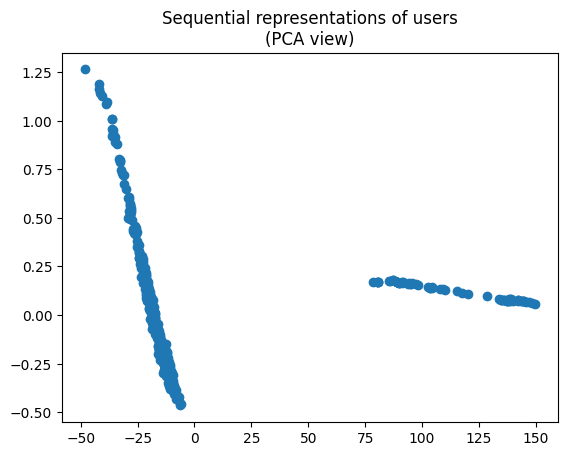

<Figure size 640x480 with 0 Axes>

In [102]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
representations_pca = pca.fit_transform(representations.detach().cpu().numpy())

plt.scatter(representations_pca[:, 0], representations_pca[:, 1])
plt.title("Sequential representations of users\n(PCA view)")
plt.show()
plt.savefig(os.path.join("..", "data", "sequential_representations.png"))

### Decoder for making predictions

In [81]:
class SequentialDecoder(nn.Module):
    def __init__(self, game_embed=512, hidden_sizes=[256, 128], emb_size=32):
        super().__init__()

        # first layer get concatenated image embedding and utime sequence embedding
        #    emb size + game_embeding -> hid1 -> hid2 ->...-> hidn -> prawdpopodobienstwo
        layers = []
        for in_size, out_size in zip(
            [emb_size + game_embed] + hidden_sizes[:-1], hidden_sizes
        ):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))

        layers.append(nn.Linear(hidden_sizes[-1], 1))
        layers.append(nn.Sigmoid())
        self.sequence = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.sequence(x)

In [82]:
def shuffle_arrays(array1, array2, array3):
    perm = np.random.permutation(len(array1))
    return array1[perm], array2[perm], array3[perm]


y_positive = np.ones(len(X_train_pos), dtype="int")
y_negative = np.ones(len(X_train_neg), dtype="int")
X_train = np.concatenate((X_train_pos, X_train_neg), axis=0)
Y_train = np.concatenate((y_positive, y_negative), axis=0)
X_lasts = np.concatenate((x_last_train_pos, x_last_train_neg), axis=0)

X_train, Y_train, X_lasts = shuffle_arrays(X_train, Y_train, X_lasts)

In [83]:
def tensors_prep(usr,game):
    last_game_embedding = torch.from_numpy(game.reshape(-1)).to(device)
    return torch.cat((usr, last_game_embedding), dim=0)

In [84]:
from statistics import mean 
def fit(
    encoder,
    decoder,
    X_train,
    X_lasts,
    Y_train,
    optimizer,
    epochs: int = 20,
):
    encoder.to(device)
    encoder.eval()
    for param in encoder.parameters():
        param.requires_grad = False
    decoder.to(device)
    for i in range(epochs):
        loss_total = []
        loss_mean = []

        for x, x_last, y in tqdm(zip(X_train, X_lasts, Y_train)):
            # choose technique randomly

            user_embed = encoder(x.to(device))
            # last_game_embedding = torch.from_numpy(x_last.reshape(-1)).to(device)
            # result = torch.cat((user_embed, last_game_embedding), dim=0)
            result = tensors_prep(user_embed, x_last)
            y_pred = decoder(result)

            y = torch.tensor(y).to(device)
            loss = y*torch.log(y_pred)
            
            loss_total.append(loss.item())
            # print(mean(loss_total))
            loss_mean.append(mean(loss_total))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    return loss_mean, loss_total, decoder

In [108]:
# with open(os.path.join("..", "data", f"encoder_20.pkl"), "rb") as f:
#     encoder = pickle.load(f)

N_EPOCHS = 30
decoder = SequentialDecoder(game_embed=512, hidden_sizes=[256,256,128], emb_size=32).to(device)
optimizer = torch.optim.Adam(encoder.parameters())

In [109]:
loss_mean, total_loss, decoder = fit(
    encoder=encoder,
    decoder=decoder,
    X_train=X_train,
    X_lasts=X_lasts,
    Y_train=Y_train,
    optimizer=optimizer,
    epochs=N_EPOCHS,
)

1546it [00:07, 202.07it/s]
1546it [00:06, 233.39it/s]
1546it [00:07, 212.28it/s]
1546it [00:06, 231.20it/s]
1546it [00:06, 222.21it/s]
1546it [00:08, 187.99it/s]
1546it [00:06, 238.07it/s]
1546it [00:07, 202.84it/s]
1546it [00:06, 231.58it/s]
1546it [00:06, 221.83it/s]
1546it [00:09, 169.64it/s]
1546it [00:06, 224.13it/s]
1546it [00:08, 180.40it/s]
1546it [00:10, 143.76it/s]
1546it [00:10, 144.51it/s]
1546it [00:10, 144.94it/s]
1546it [00:10, 143.47it/s]
1546it [00:10, 140.77it/s]
1546it [00:10, 143.20it/s]
1546it [00:10, 141.17it/s]
1546it [00:10, 142.71it/s]
1546it [00:10, 143.94it/s]
1546it [00:10, 143.66it/s]
1546it [00:10, 150.33it/s]
1546it [00:10, 152.46it/s]
1546it [00:09, 155.33it/s]
1546it [00:10, 154.50it/s]
1546it [00:09, 157.34it/s]
1546it [00:09, 163.44it/s]
1546it [00:09, 171.76it/s]


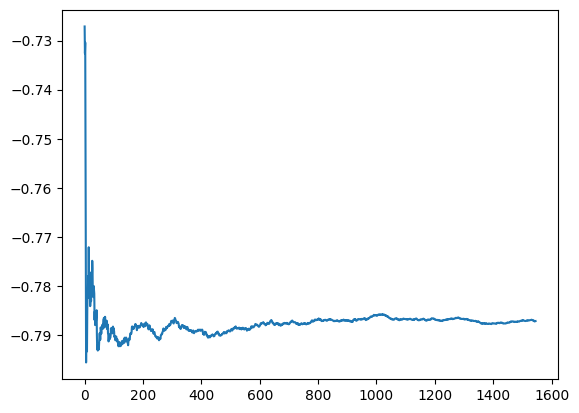

In [110]:
import matplotlib.pyplot as plt

ys = loss_mean
xs = [x for x in range(len(ys))]

plt.plot(xs, ys)
plt.savefig(os.path.join("..", "data","loss.png"))
plt.show()


In [88]:
with open(os.path.join("..", "data", f"decoder_{N_EPOCHS}.pkl"), "wb") as f:
    pickle.dump(decoder, f)

Prediction function

In [95]:
def predict_for_user(user_seq, games_embeds, encoder, decoder):
    encoder.eval()
    decoder.eval()
    encoder.to(device)
    decoder.to(device)
    games_preds = []
    with torch.no_grad():
        user_embed = encoder(user_seq.to(device))
        for game in games_embeds:
            # result = tensors_prep(user_embed, game)
            game_embedding = game.reshape(-1).to(device)
            result = torch.cat((user_embed, game_embedding), dim=0)
            y_pred = decoder(result)
            games_preds.append(y_pred)

    max_idx = games_preds.index(max(games_preds))
    return games_embeds[max_idx]

In [96]:
def predict_on_test(X_test, X_last, encoder, decoder, game_embeds, games_list):
    y_preds = []
    print(type(X_last[0]))
    for x in X_test:
        game = predict_for_user(x, game_embeds, encoder, decoder)
        y_preds.append(game.cpu().numpy())
    
    y_pred,y_true =[], []
    for pred, y in zip(y_preds, X_last):

        if np.all(pred == y):
            y_true.append(1)
            y_pred.append(1)
        else:
            y_true.append(1)
            y_pred.append(0)

    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: { recall_score(y_true, y_pred)}")
    print(f"F1 score: {f1_score(y_true, y_pred)}")
    # print(f"Confucion matrix: " + confusion_matrix(y_true, y_pred))

In [97]:
X_test = np.concatenate((X_test_pos, X_test_neg), axis=0)
X_test_last = np.concatenate((x_last_test_pos, x_last_test_neg), axis=0)

In [98]:
with open(os.path.join("..", "data",'x_test.npy'), 'wb') as f:
    np.save(f, X_test)

with open(os.path.join("..", "data",'x_test_last.npy'), 'wb') as f:
    np.save(f, X_test_last)

In [99]:
# with open(os.path.join("..", "data", f"encoder_20.pkl"), "rb") as f:
#     encoder = pickle.load(f)
# with open(os.path.join("..", "data", f"decoder_20.pkl"), "rb") as f:
#     decoder = pickle.load(f)

games_list = list(set(games_list))
games_embeds = []
for game in games_list:
    games_embeds.append(items_embs[game].to(device))

In [100]:
predict_on_test(
    encoder=encoder,
    decoder=decoder,
    X_test=X_test,
    X_last=X_test_last,
    game_embeds=games_embeds,
    games_list=games_list,
)

<class 'numpy.ndarray'>
Accuracy: 0.0
Precision: 0.0
Recall: 0.0
F1 score: 0.0


c:\Users\julia\Desktop\sem2\analiza_mediów\amc_env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
